In [30]:
import librosa
import math
import numpy as np
import os
import pandas as pd

from glob import glob
from matplotlib import pyplot as plt
from python_speech_features import mfcc, logfbank
from scipy.io import wavfile

In [97]:
nfilt = 26
sampling_freq = 16000  # Observed from the dataset

window_size = 0.025  # 25 ms
num_points = 1 / window_size  # 1 sec / window_size = 40 points
# Window size is 25 ms.
# 1 sec / 40 points = 25 ms
# Sampling freq = 16,000
# 16,000 / 40 = 400
nfft =  math.ceil(sampling_freq / num_points)  # 400

numcep = 13  # Typically half of nfilt
# threshold = 0.0005
threshold = 400

In [98]:
def calc_fft(signal, rate):
    n = len(signal)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(signal)/n)
    return (Y, freq)


def envelop(signal, rate, threshold):
    mask = []
    y = pd.Series(signal).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [99]:
def plot_signals(signals):
    fig,axes = plt.subplots(nrows=4, ncols=5, sharex=False, sharey=True, figsize=(20, 10))
    fig.suptitle('Time series', size=16)
    i = 0
    for x in range(4):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [100]:
def plot_fft(fft):
    fig,axes = plt.subplots(nrows=4, ncols=5, sharex=False,
                           sharey=True, figsize=(20,10))
    fig.suptitle('Fourier Transform', size=16)
    i = 0
    for x in range(4):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0],data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq,Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [101]:
def plot_fbank(fbank):
    fig,axes = plt.subplots(nrows=4, ncols=5, sharex=False,
                           sharey=True, figsize=(20,10))
    fig.suptitle('Filter Bank Coefficient',size=16)
    i = 0
    for x in range(4):
        for y in range(5):
            data = list(fft.values())[i]
            Y,freq = data[0], data[1]
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                             cmap='hot',interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [102]:
def plot_mfccs(mfccs):
    fig,axes = plt.subplots(nrows=4, ncols=5, sharex=False,
                           sharey=True, figsize=(20,10))
    fig.suptitle('Mel Frequency Cepstrum Coefficients',size=16)
    i = 0
    for x in range(4):
        for y in range(5):
            data= list(mfccs.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                             cmap='hot',interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [103]:
input_dir = "speaker"
rows = []
for file in glob(os.path.join(input_dir, "*", "*")):
    label = os.path.basename(os.path.dirname(file))
    rows.append([file, label])
df = pd.DataFrame(rows, columns=["file", "label"])
df.set_index("file", inplace=True)
df.head()

,label
file,
speaker\0016\00001.wav,0016
speaker\0016\00002.wav,0016
speaker\0016\00003.wav,0016
speaker\0016\00004.wav,0016
speaker\0016\00005.wav,0016


In [104]:
for f in df.index:
    rate, signal = wavfile.read(f)
    df.at[f, "length"] = signal.shape[0] / rate
df.head()

,label,length
file,,
speaker\0016\00001.wav,0016,23.080063
speaker\0016\00002.wav,0016,8.000063
speaker\0016\00003.wav,0016,14.200062
speaker\0016\00004.wav,0016,12.760063
speaker\0016\00005.wav,0016,7.840063


In [105]:
classes = list(np.unique(df.label))
class_dist = df.groupby('label').length.mean()

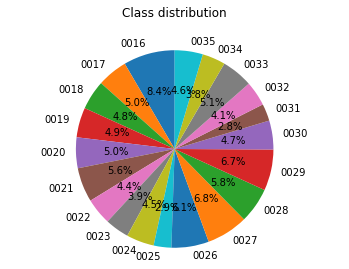

In [106]:
fig, ax = plt.subplots()
ax.set_title("Class distribution", y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct="%1.1f%%", shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [107]:
df.reset_index(inplace=True)
df.head()

,file,label,length
0,speaker\0016\00001.wav,0016,23.080063
1,speaker\0016\00002.wav,0016,8.000063
2,speaker\0016\00003.wav,0016,14.200062
3,speaker\0016\00004.wav,0016,12.760063
4,speaker\0016\00005.wav,0016,7.840063


In [108]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = df[df.label==c].iloc[0, 0]
#     signal, rate = librosa.load(wav_file, sr=44100)
    rate, signal = wavfile.read(wav_file)
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    fbank[c] = logfbank(signal[:rate], rate, nfilt=nfilt, nfft=nfft).T
    mfccs[c] = mfcc(signal[:rate], rate, numcep=numcep, nfilt=nfilt, nfft=nfft).T

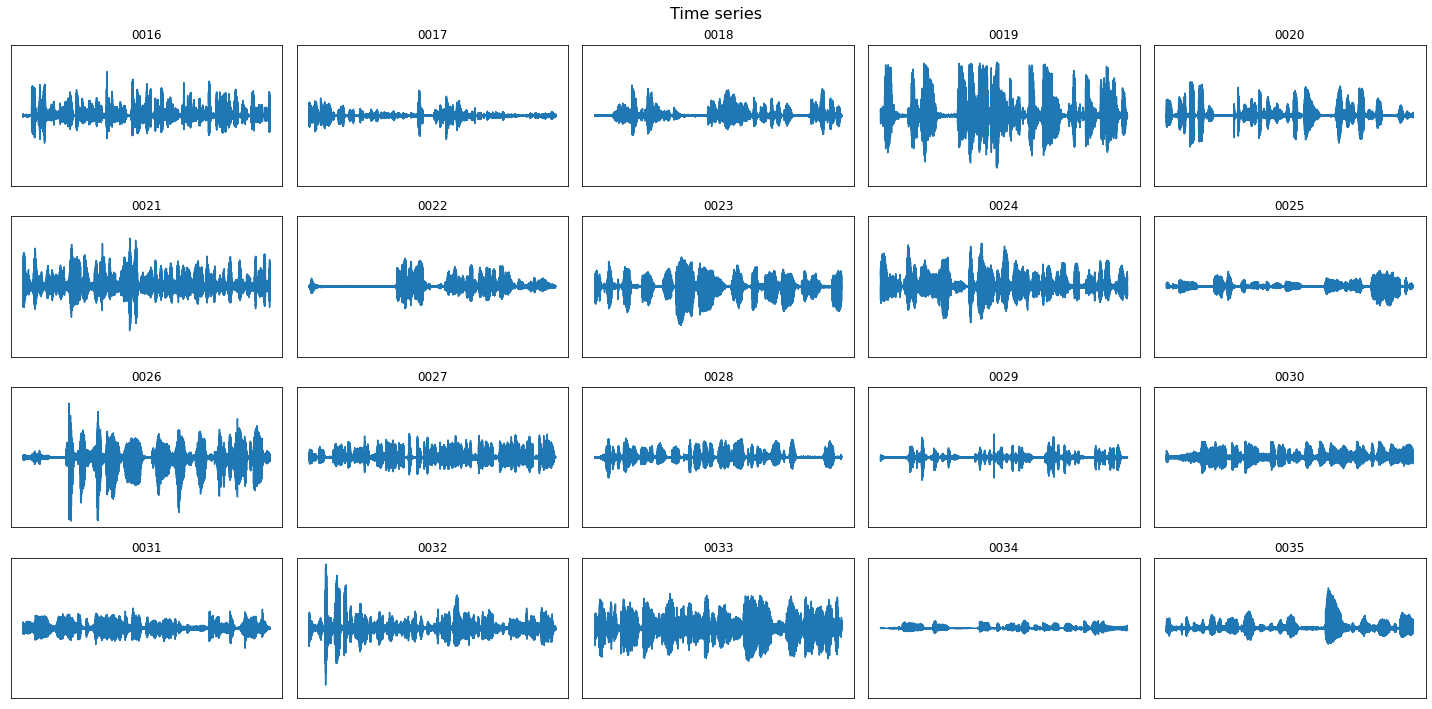

In [109]:
plot_signals(signals)
plt.tight_layout()
plt.show()

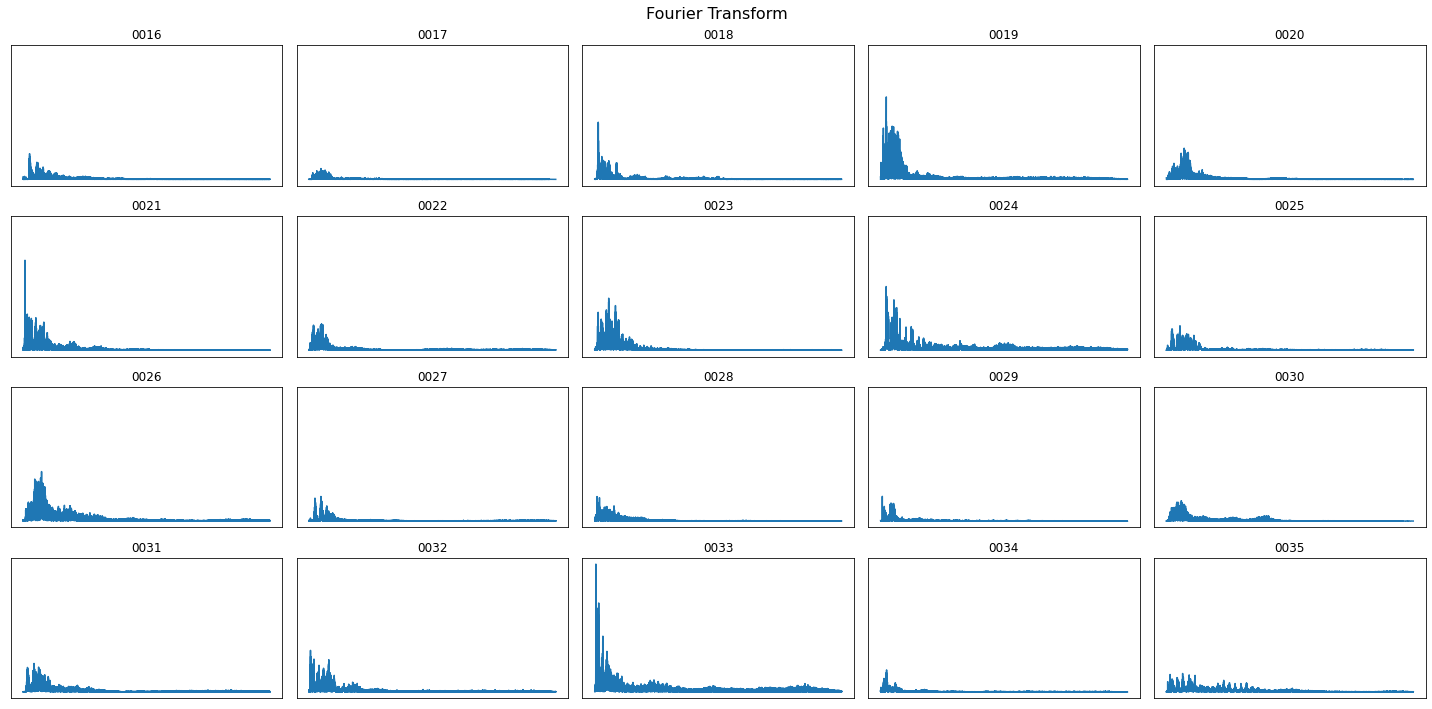

In [110]:
plot_fft(fft)
plt.tight_layout()
plt.show()

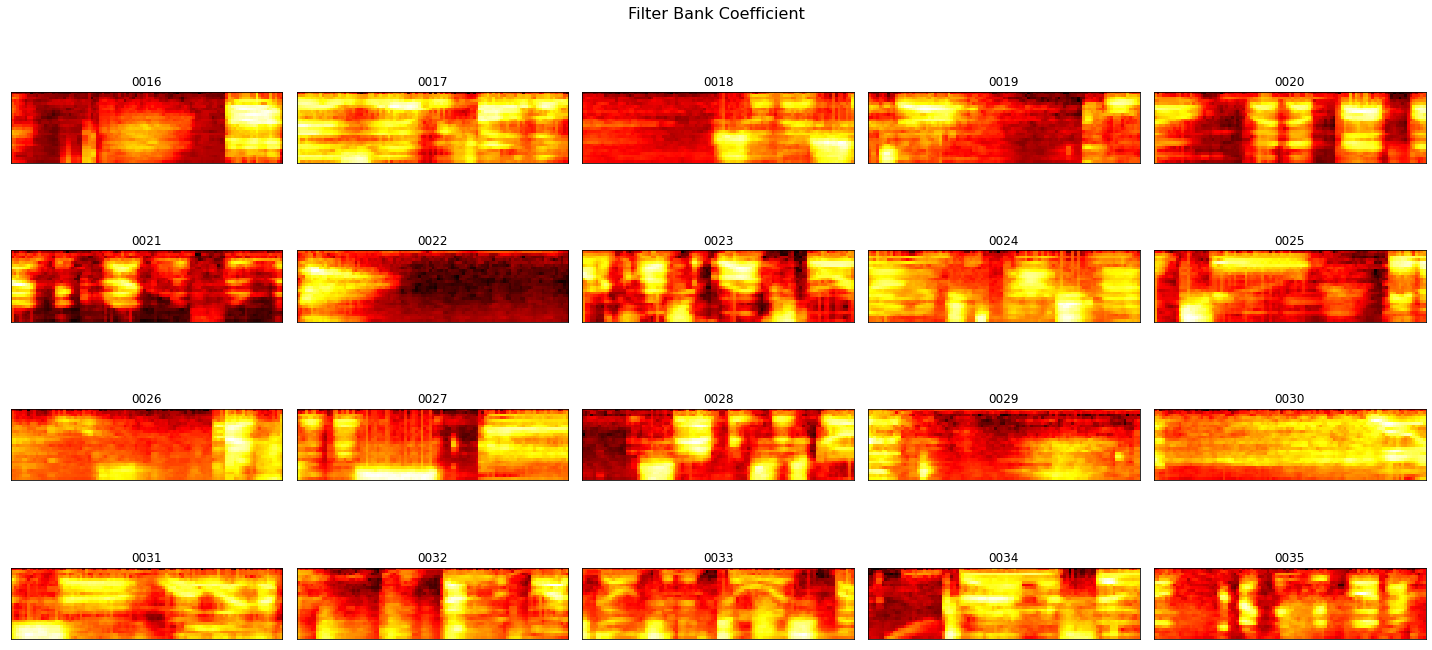

In [111]:
plot_fbank(fbank)
plt.tight_layout()
plt.show()

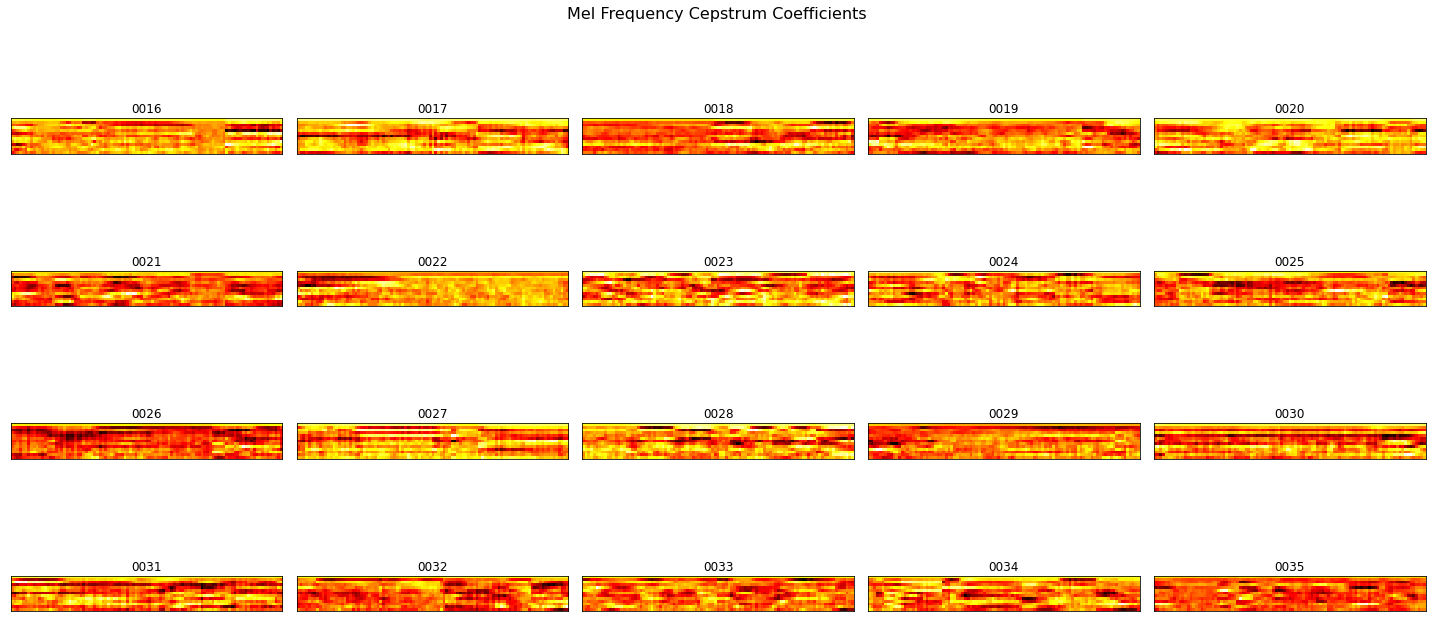

In [112]:
plot_mfccs(mfccs)
plt.tight_layout()
plt.show()

In [121]:
clean_signals = {}
clean_fft = {}
clean_fbank = {}
clean_mfccs = {}
for c in classes:
    wav_file = df[df.label==c].iloc[0, 0]
#     signal, rate = librosa.load(wav_file, sr=44100)
    rate, signal = wavfile.read(wav_file)
    
    # Get rid of dead space in the audio
    mask = envelop(signal, rate, threshold)
#     print(len(signal), len(signal[mask]))
    signal = signal[mask]
        
    clean_signals[c] = signal
    clean_fft[c] = calc_fft(signal, rate)
    clean_fbank[c] = logfbank(signal[:rate], rate, nfilt=nfilt, nfft=nfft).T
    clean_mfccs[c] = mfcc(signal[:rate], rate, numcep=numcep, nfilt=nfilt, nfft=nfft).T

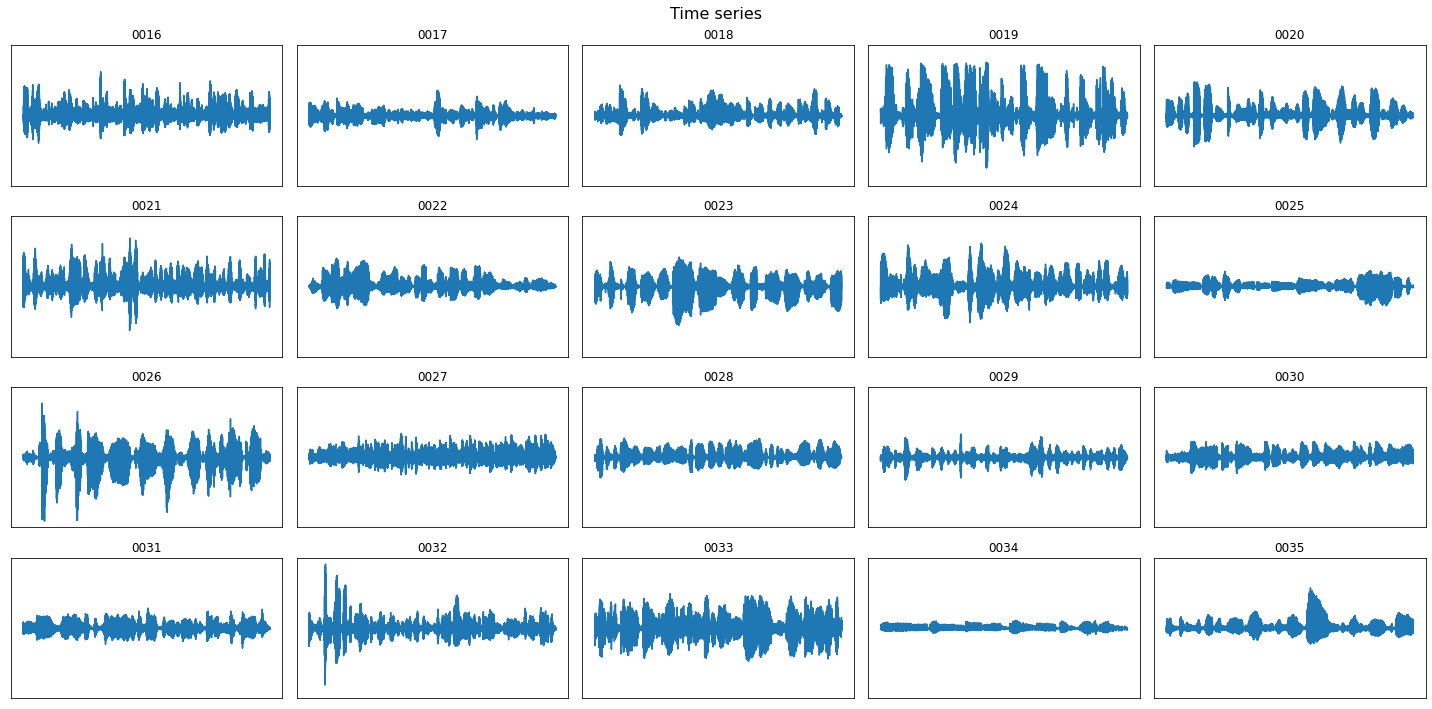

In [114]:
plot_signals(clean_signals)
plt.tight_layout()
plt.show()

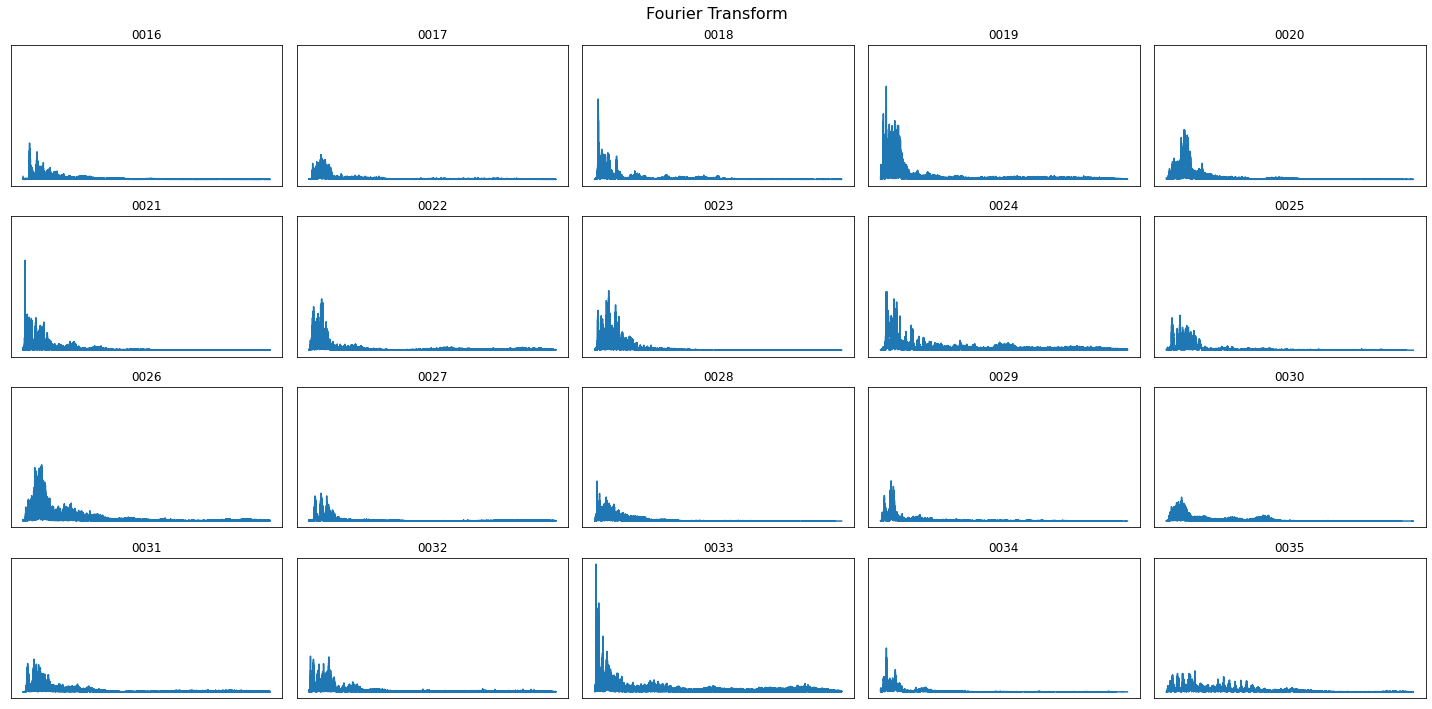

In [116]:
plot_fft(clean_fft)
plt.tight_layout()
plt.show()

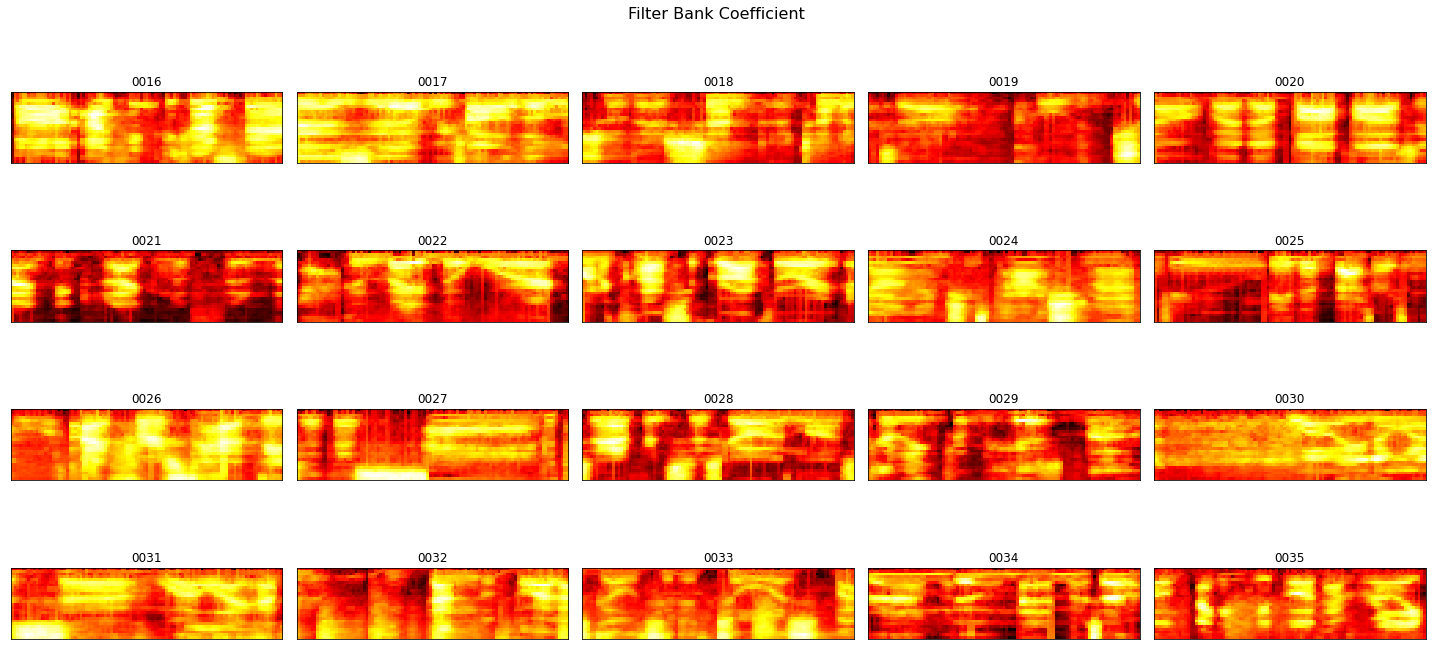

In [118]:
plot_fbank(clean_fbank)
plt.tight_layout()
plt.show()

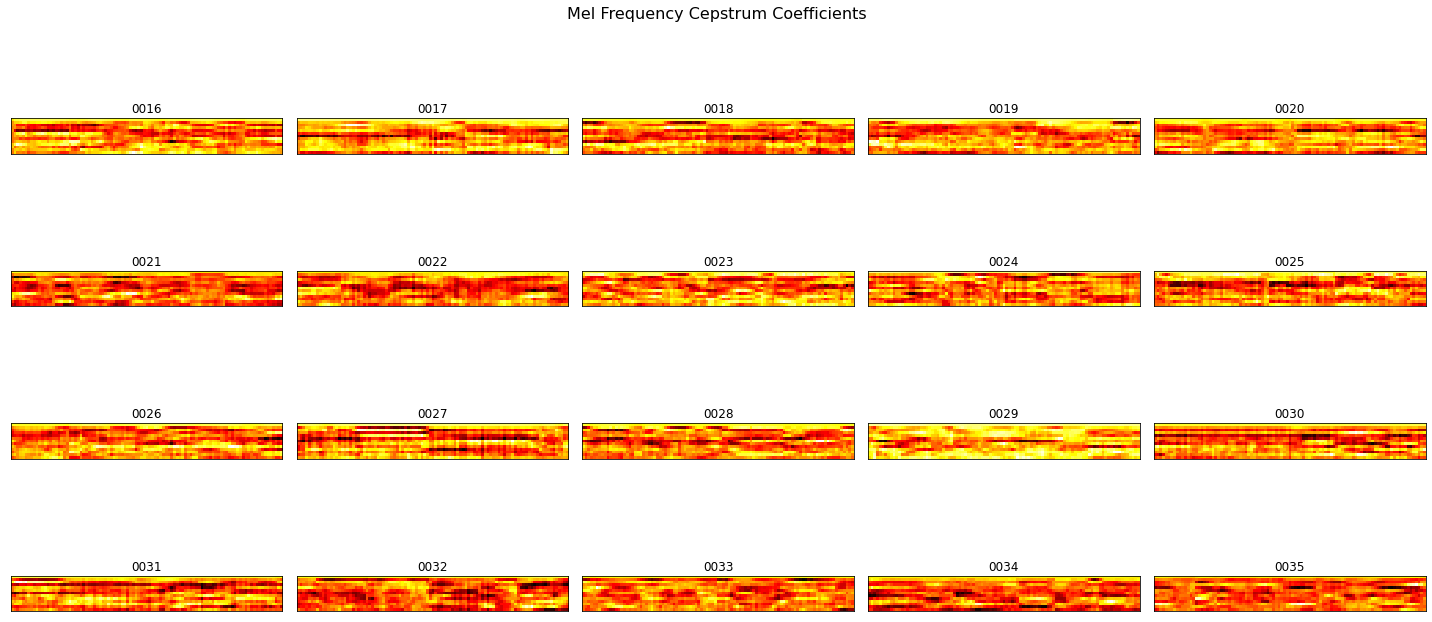

In [119]:
plot_mfccs(clean_mfccs)
plt.tight_layout()
plt.show()